# First run from Alex

Imports...

In [1]:
import pandas
import matplotlib.pyplot as plt

Load the data...

In [2]:
timing = pandas.read_csv("./training_timing.csv")
timing

,epoch,batch,location,mem (gb)
0,0,0,before training anything,31.928013
1,0,0,before training adversary (1),31.927497
2,0,0,after training adversary (1),33.117176
3,0,0,after training adversary (2),33.169699
4,0,0,before training main model,33.169699
...,...,...,...,...
2482,8,7,before training anything,89.236726
2483,8,7,before training adversary (1),89.237742
2484,8,7,after training adversary (1),89.260425
2485,8,7,after training adversary (2),89.277014


We need some sort of timing thing. Use `epoch*n_batch + batch_number`.

In [3]:
timing['time'] = timing.epoch*timing.batch.max() + timing.batch
timing

,epoch,batch,location,mem (gb),time
0,0,0,before training anything,31.928013,0
1,0,0,before training adversary (1),31.927497,0
2,0,0,after training adversary (1),33.117176,0
3,0,0,after training adversary (2),33.169699,0
4,0,0,before training main model,33.169699,0
...,...,...,...,...,...
2482,8,7,before training anything,89.236726,407
2483,8,7,before training adversary (1),89.237742,407
2484,8,7,after training adversary (1),89.260425,407
2485,8,7,after training adversary (2),89.277014,407


## Simple memory plots vs time

Look at each as a function of time... Given the total increase in each data set is some number, I'm not sure these different plots are going to do anything but look the same.

First, get a list of all the items in there.

In [4]:
location_names = timing.location.unique()
location_names

array(['before training anything', 'before training adversary (1)',
       'after training adversary (1)', 'after training adversary (2)',
       'before training main model', 'after batches are done',
       'after model test_on_batch', 'after adv test_on_batch',
       'before reloading weights', 'after reloading weights'],
      dtype=object)

Second, a simple function to plot one of the items as a function of "time".

In [5]:
def plot_single_timing(data: pandas.DataFrame, name: str):
    '''Plot the data `name` vs the `time` column as a line plot.

    Args:
        data (pandas.DataFrame): The data to plot
        name (str): The name of the type of data to plot
    '''
    x_values = data[data.location == name].time
    y_values = data[data.location == name]['mem (gb)']

    plt.plot(x_values, y_values, '-o')
    plt.xlabel('Time [epoch*n_batch + batch]')
    plt.ylabel('Memory [GB]')
    plt.title(name)
    plt.show()


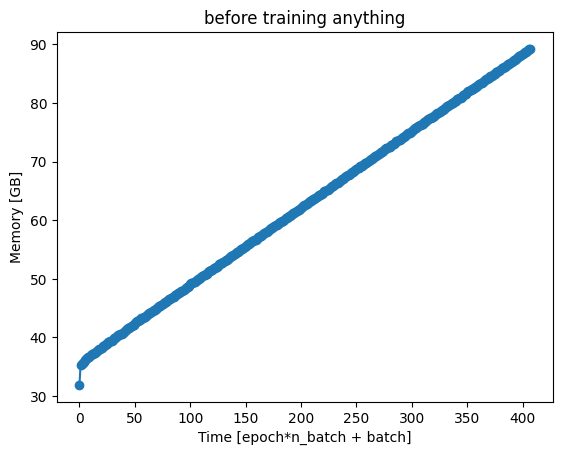

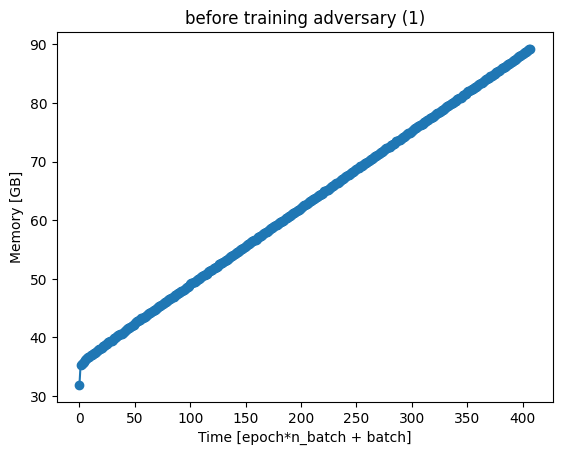

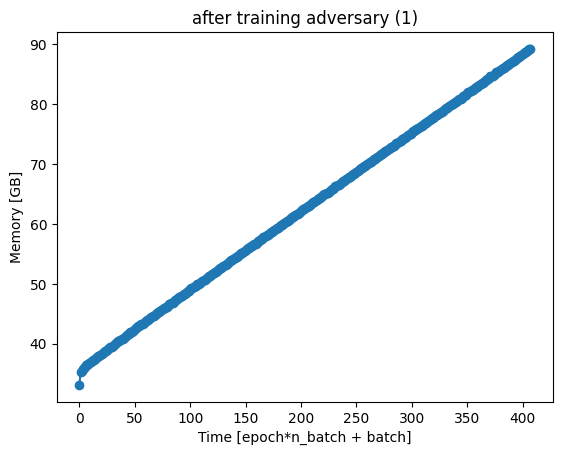

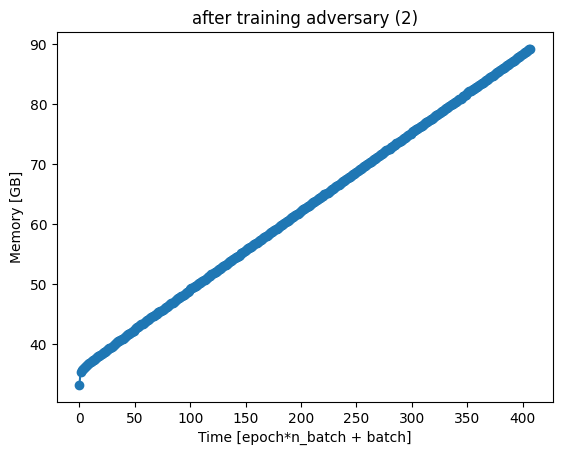

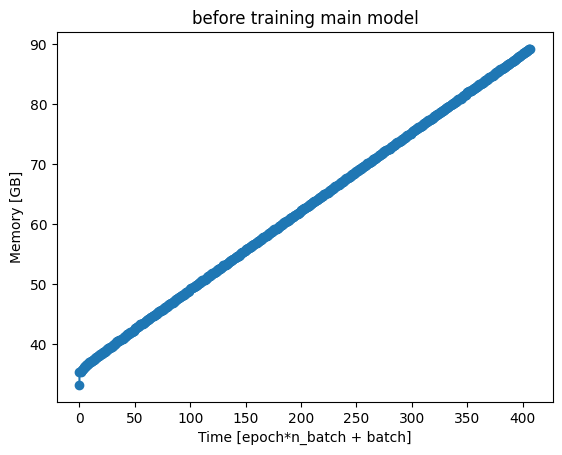

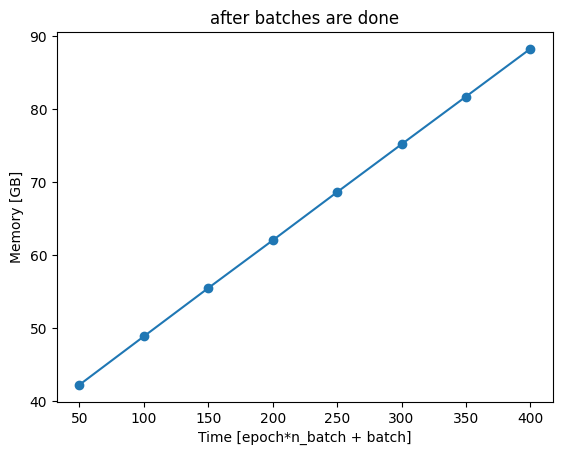

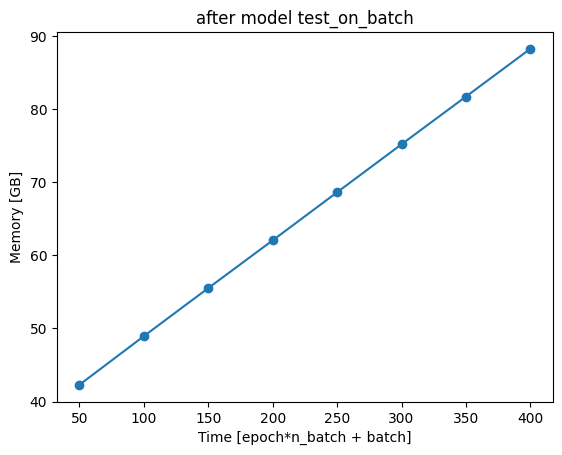

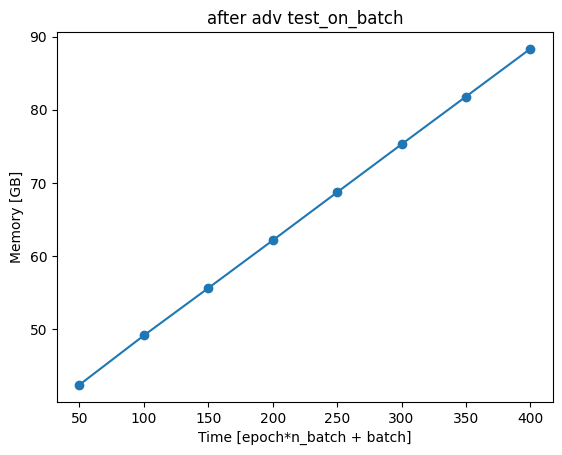

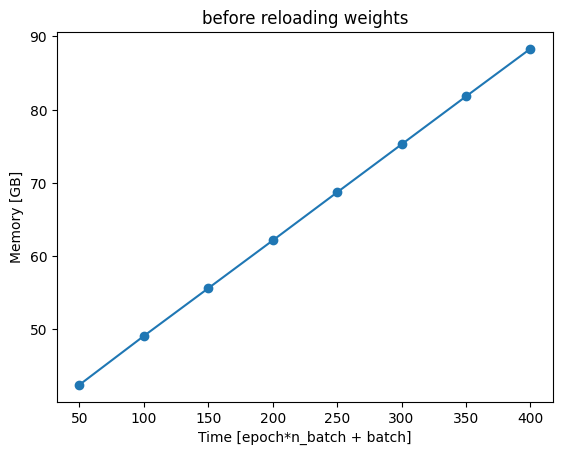

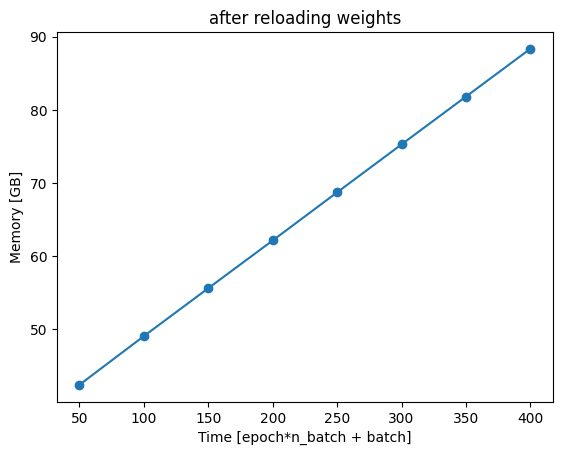

In [6]:
for n in location_names:
    plot_single_timing(timing, n)

## Plotting differences

It is probably much more interesting understanding the deltas between steps. Take adjacent steps, and look at a histogram of those differences.

First, get a list of the steps in order. Slightly non-trivial in case the same name is repeated.

In [7]:
first_name = timing.location[0]
sequence_length = -1
for i in range(1, len(timing)-1):
    if timing.location[i] == first_name:
        sequence_length = i
        break

assert sequence_length > 0
print(f'Measurements points per batch {sequence_length}')

Measurements points per batch 6


Plot a histogram of an arbitrary pairing.

* *TODO*: The last-first is a wrap around - need to provide a flag for that, so we shift values down one! Not yet attempted because the wrap occurs on something that is duplicated.

In [8]:
def plot_delta_memory(data: pandas.DataFrame, name_0: str, name_1: str):
    '''Plots the change in memory for each mini-batch between steps `name_0` and `name_1`

    Basically a histogram of `name_1 - name_0`.
        
    Args:
        data (pandas.DataFrame): Timing Data
        name_0 (str): The first step.
        name_1 (str): The second step.
    '''
    time_0 = data[data.location == name_0].time
    y_values_0 = data[data.location == name_0]['mem (gb)'].values
    time_1 = data[data.location == name_1].time
    y_values_1 = data[data.location == name_1]['mem (gb)'].values

    assert len(time_0) == len(time_1)
    # assert time_0.equals(time_1)

    delta = y_values_1 - y_values_0
    plt.hist(delta, bins=50)
    plt.xlabel('Change In Memory')
    plt.xlabel('Memory [GB]')
    plt.title(f'Memory at {name_1} minus {name_0}')
    plt.show()

Unable to plot (before training main model, before training anything): 


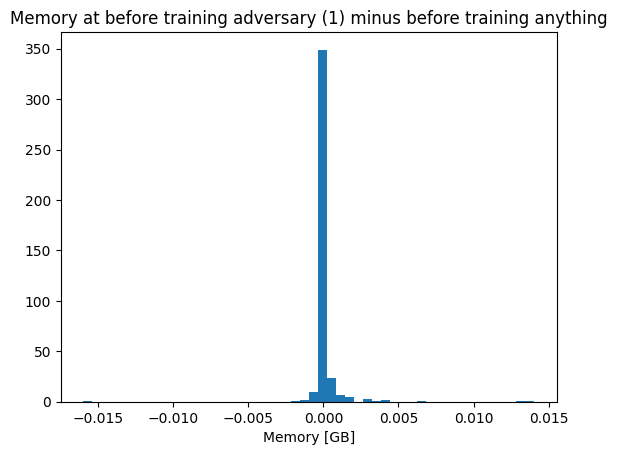

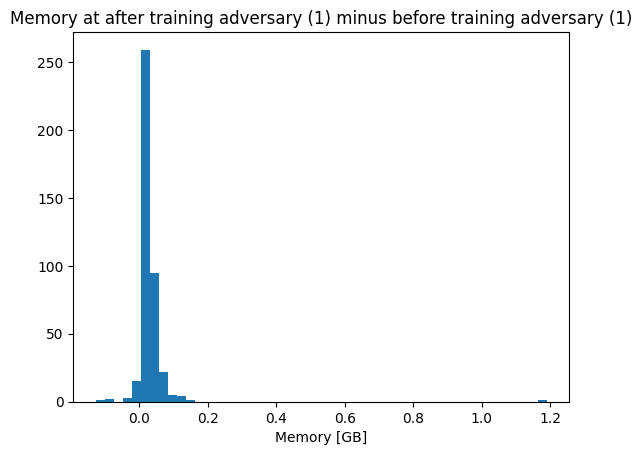

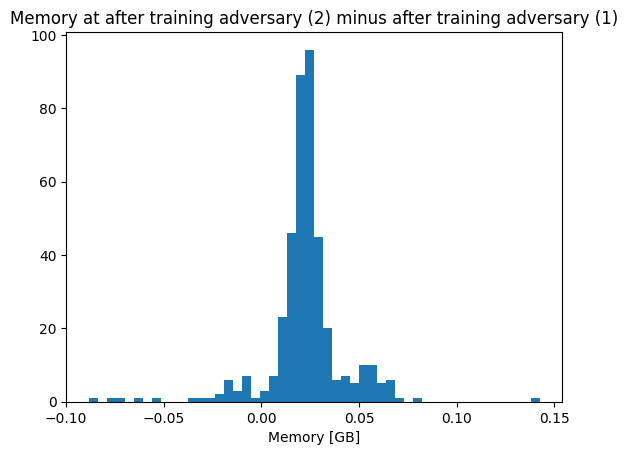

Unable to plot (after training adversary (2), before training main model): 


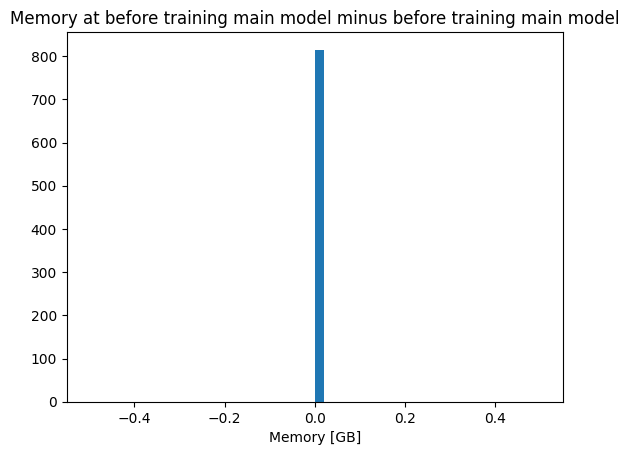

In [9]:
last_plot = timing.location[sequence_length-1]
for index in range(0, sequence_length):
    try:
        plot_delta_memory(timing, last_plot, timing.location[index])
    except Exception as e:
        print(f'Unable to plot ({last_plot}, {timing.location[index]}): {str(e)}')
    last_plot = timing.location[index]